# Homework 2

## ASTR 5900

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sherpa.data import Data2D
from sherpa.models.basic import Polynom2D, Gauss2D
from sherpa.astro.models import Lorentz2D
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar
from sherpa.fit import Fit

# Problem 1

This homework will probe your data analysis skills and propagation of errors.

The file "data_points" that you can download from Canvas contains the X and Y positions of photons.  The image that they comprise consists of a non-uniform background, and a astronomical object.  

Your goal is to determine the net number of photons in the astronomical object and the uncertainty on that net number.

Hints:
 - You will probably want to create and work on a 2-d histogram representation of the data.  That can be accomplished using `plt.hist2d`.
 - You will probably want to create a model for the background.
 
The format of the data is a "pickle file".  That can be reconstituted to the x and y data points as below.

In [2]:
# import pickle
# filename='data_points'
# file=open(filename,'rb')
# temp=pickle.load(file)

# xdata=temp[0]
# ydata=temp[1]

#### Answer:

For the background, I assumed a 2D plane model. Then, for the PSF I first tried a 2D Gaussian and then a 2D Lorentzian. I wound up optimizing based on the least squares. I also tried using $\chi^2$ using bin count errors of $\sqrt{N}$ for each bin, however this gave very different results for the number of total counts, so I decided against it.

Ultimately, my Gaussian profile had a lower statistic (least square) and therefore I assume this as my PSF for the object. I subtracted the fit planar model corresponding to the background to get just the PSF. Then I integrated all the flux/counts to get a total of about $N_{tot} = 11,744$ counts. As for the uncertainty, I assume each bin has an uncertainty of $\sqrt{N}$, and when you add each bin in quadrature to get the uncertainty in $N_{tot}$, you just get $\sqrt{N_{tot}}$. So, ultimately I find the number of counts to be $\boxed{N_{tot} = 11,744 \pm 108}$ counts.

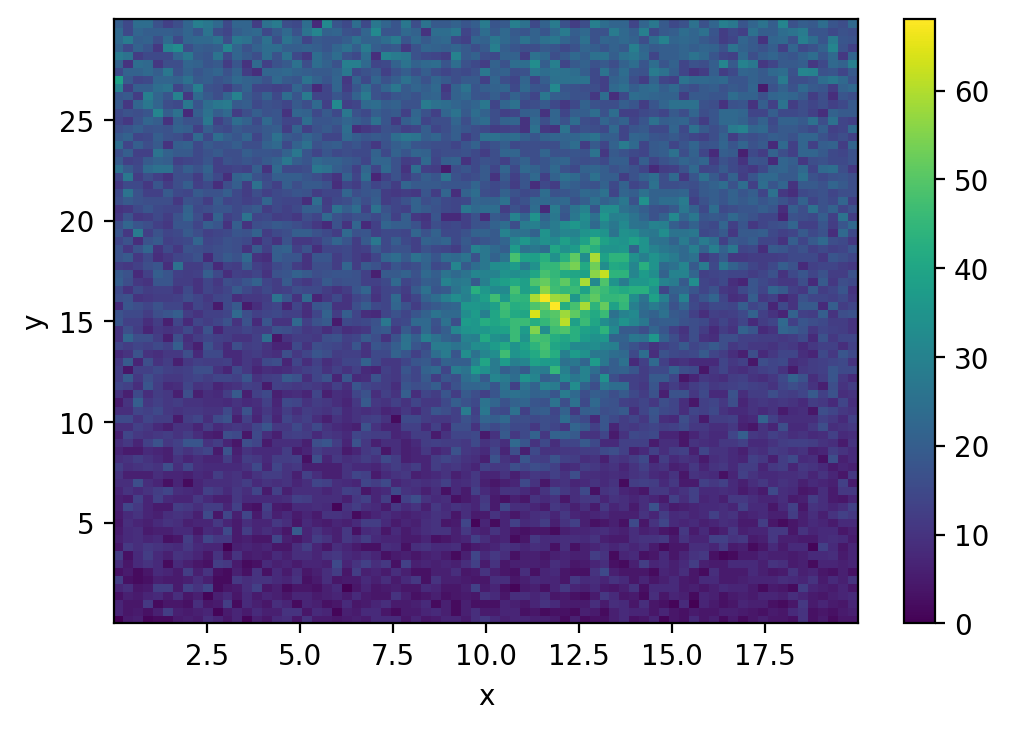

In [3]:
fn = 'data_points'
with open(fn, 'rb') as F:
    X, Y = pickle.load(F)

fig, ax = plt.subplots(dpi=200)

bins = 75
h, x, y, scmap = ax.hist2d(X, Y, bins=(bins, bins), cmap='viridis')
x = (x[:-1] + x[1:]) / 2
y = (y[:-1] + y[1:]) / 2

fig.colorbar(scmap, ax=ax)

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

Method                = levmar
Statistic             = leastsq
Initial fit statistic = 85815.6
Final fit statistic   = 85815.6 at function evaluation 12
Data points           = 5625
Degrees of freedom    = 5615
Change in statistic   = 0
   plane.c        5.31251      +/- 0.053726    
   plane.cy1      -0.00882648  +/- 0.00309509  
   plane.cx1      0.790137     +/- 0.00463373  
   plane.cx1y1    4.02165e-05  +/- 0.000268607 
   gauss.fwhm     7.21046      +/- 0.0224419   
   gauss.xpos     10.6128      +/- 0.00578577  
   gauss.ypos     17.9376      +/- 0.00890061  
   gauss.ellip    0.4444       +/- 0.00234714  
   gauss.theta    1.22387      +/- 0.00339544  
   gauss.ampl     38.2721      +/- 0.114173    
number of counts: 11744.14 +/- 108.37


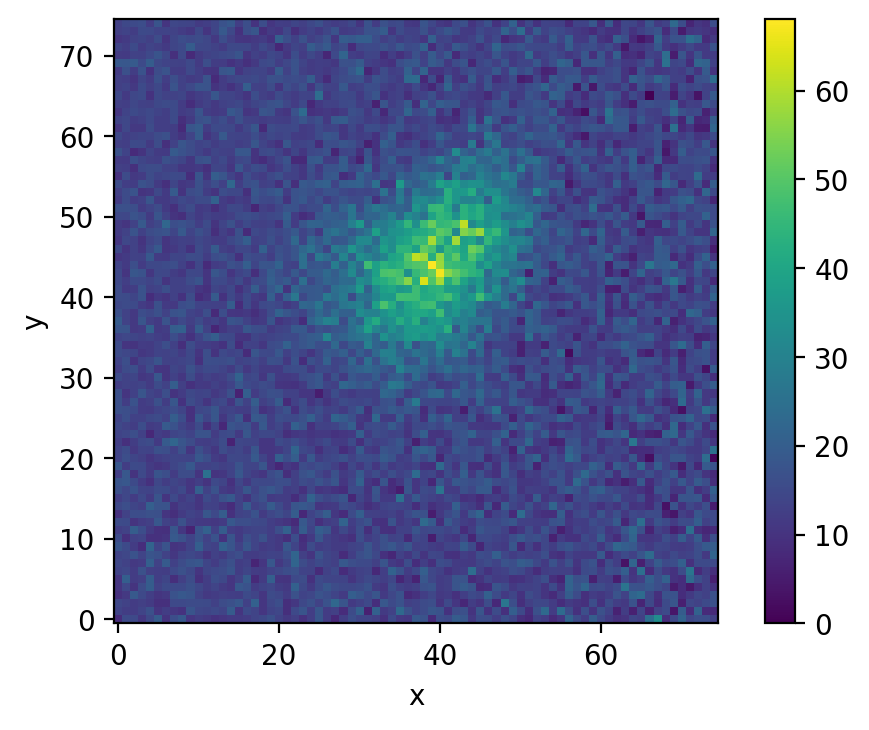

In [4]:
x_mesh, y_mesh = np.meshgrid(x, y)
data = Data2D('image', x_mesh.ravel(), y_mesh.ravel(), h.ravel())

# assume a plane background model
plane = Polynom2D('plane')
for param in plane.pars:
    param.frozen = True
plane.c.frozen = False
plane.cx1.frozen = False
plane.cy1.frozen = False
plane.cx1y1.frozen = False

# gaussian psf model
gauss = Gauss2D('gauss')
gauss.ellip.frozen = False
gauss.theta.frozen = False
gauss.xpos = np.median(x)
gauss.ypos = np.median(y)
gauss.ampl = h.max()

model1 = plane + gauss

# fit gaussian model
def converge_fit(*args, **kwargs):
    count = 0
    while count < 10:
        fit = Fit(*args, **kwargs)
        out = fit.fit()
        if out.dstatval == 0:
            break
        count += 1

    return out

out1 = converge_fit(data, model1, stat=LeastSq(), method=LevMar())
print(out1.format())

# get number of counts
y_bg1 = plane(data.x0, data.x1).reshape(bins, bins)
y_psf1 = h - y_bg1

n_counts = y_psf1.sum()
en_counts = np.sqrt(n_counts)
print(f'number of counts: {n_counts:.2f} +/- {en_counts:.2f}')

# plot
fig, ax = plt.subplots(dpi=200)

ax.imshow(y_psf1, interpolation='none')

fig.colorbar(scmap, ax=ax)

ax.invert_yaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

Method                = levmar
Statistic             = leastsq
Initial fit statistic = 92835.4
Final fit statistic   = 92835.4 at function evaluation 12
Data points           = 5625
Degrees of freedom    = 5615
Change in statistic   = 0
   plane.c        2.89362      +/- 0.0581897   
   plane.cy1      0.0201371    +/- 0.003258    
   plane.cx1      0.879564     +/- 0.00491146  
   plane.cx1y1    -0.0067077   +/- 0.000287905 
   lorentz.fwhm   5.75476      +/- 0.0284043   
   lorentz.xpos   10.6433      +/- 0.00583732  
   lorentz.ypos   17.9951      +/- 0.00891014  
   lorentz.ellip   0.446122     +/- 0.00265262  
   lorentz.theta   1.21341      +/- 0.00381656  
   lorentz.ampl   47.5251      +/- 0.180093    
number of counts: 23569.93 +/- 153.53


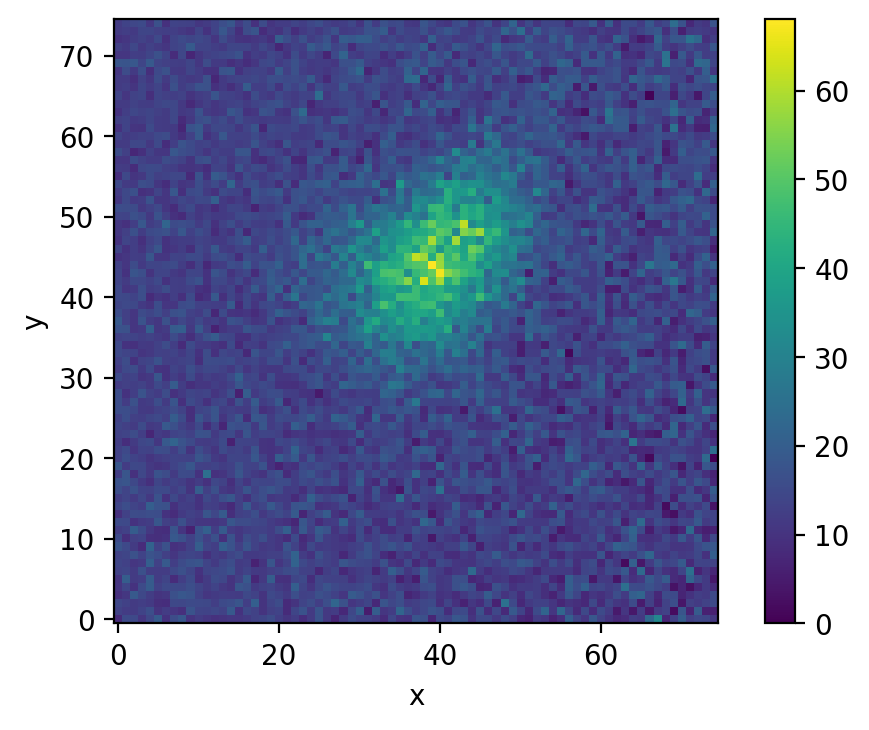

In [5]:
# lorentz psf model
lorentz = Lorentz2D('lorentz')
lorentz.ellip.frozen = False
lorentz.theta.frozen = False
lorentz.xpos = np.median(x)
lorentz.ypos = np.median(y)
lorentz.ampl = h.max()

model2 = plane + lorentz

# fit lorentz model
out2 = converge_fit(data, model2, stat=LeastSq(), method=LevMar())
print(out2.format())

# get number of counts
y_bg2 = plane(data.x0, data.x1).reshape(bins, bins)
y_psf2 = h - y_bg2

n_counts = y_psf2.sum()
en_counts = np.sqrt(n_counts)
print(f'number of counts: {n_counts:.2f} +/- {en_counts:.2f}')

# plot
fig, ax = plt.subplots(dpi=200)

ax.imshow(y_psf2, interpolation='none')

fig.colorbar(scmap, ax=ax)

ax.invert_yaxis()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

# Problem 2

In this problem we will be playing with bivariate Gaussian distributions.  Let's interpret the 2 random variables as the positions of 2 particles in a 1D well ($X_1, X_2$).

The mean and variance of the position of particle 1 is $\mu_1 = 3$, $\sigma^2_1 = 1.5$.  For particle 2 we have $\mu_2 = 2$ and $\sigma^2_2 = 5$.  The positions for both particles are distributed normally.

### Part A



Determine the probability that $-1 \leq x_1 \leq 3$ AND $ 1 \leq x_2 \leq 4$.  Assume the positions of the particles are distributed as described above, and that the random variables are independent.  Calculate this probability by sampling $10^4$ points from the relevant distribution(s), and finding the fraction of sampled points that meet the criteria.  Use routines from [`numpy.random` (this is a hyperlink)](https://docs.scipy.org/doc/numpy-1.15.1/reference/routines.random.html) to sample.  Plot the sampled points on a simple scatter plot with `matplotlib.pyplot` (Plot $x_2$ vs $x_1$).

Note: remember the difference between variance and standard deviation.

### Answer:

I found this probability to be $P \approx 0.24$.

probability: 0.2429


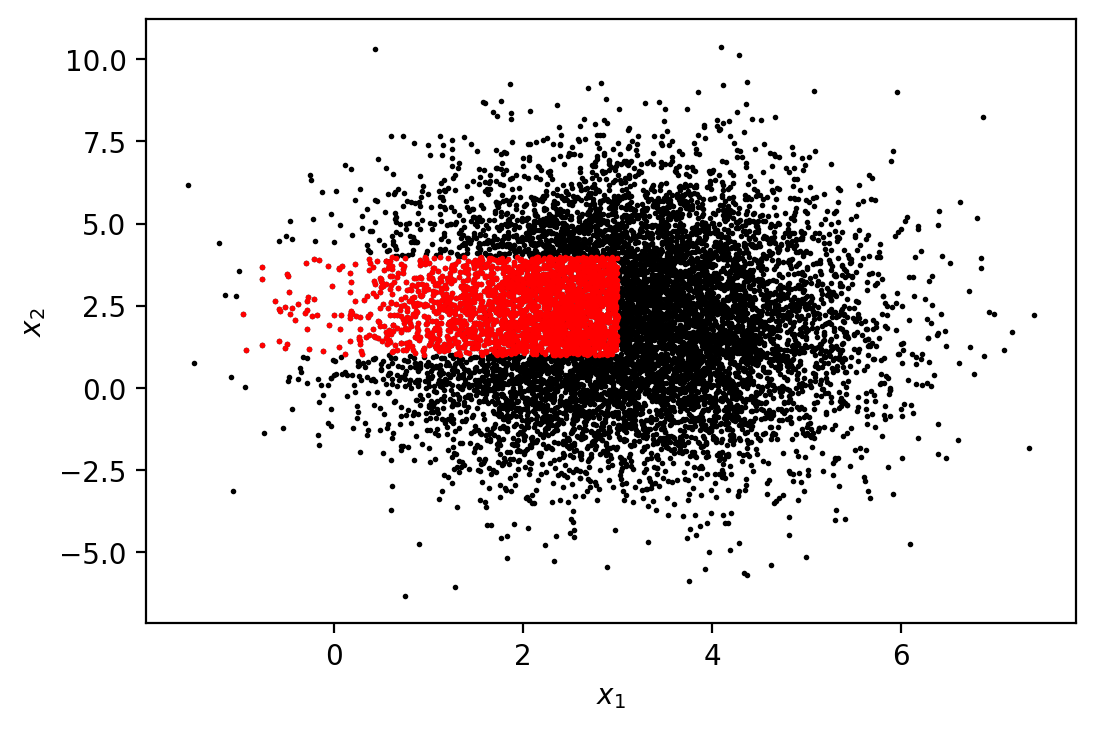

In [6]:
mu = np.array([3., 2.])
cov = np.diag([1.5, 5.])   # diagonal because vars are independent

N = 10000
samples = np.random.multivariate_normal(mu, cov, size=N)

mask = (-1. <= samples[:, 0]) & (samples[:, 0] <= 3.) & \
       (1. <= samples[:, 1]) & (samples[:, 1] <= 4.)
prob = len(samples[mask]) / N
print(f'probability: {prob}')

plt.close('all')
fig, ax = plt.subplots(dpi=200)

ax.plot(samples[:, 0], samples[:, 1], 'o', c='k', ms=1)
ax.plot(samples[mask][:, 0], samples[mask][:, 1], 'o', c='r', ms=1)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

### Part B

Calculate the probability of the same criteria, except now assume the positions are not independent (maybe the particles interact).  Use $\text{Cov}(X_1, X_2) = 3$.  Again there is a relevant `numpy.random` routine that will allow you to do the relevant sampling. Plot the sampled points.

Hint: This amounts to off-diagonal terms in the covariance matrix.  If you sampled from two independent 1D Gaussians in Part A, you should realize you can no longer do the same thing in this section.

### Answer:

I just change the covariance matrix accordingly to get my answer of $P \approx 0.20$.

probability: 0.208


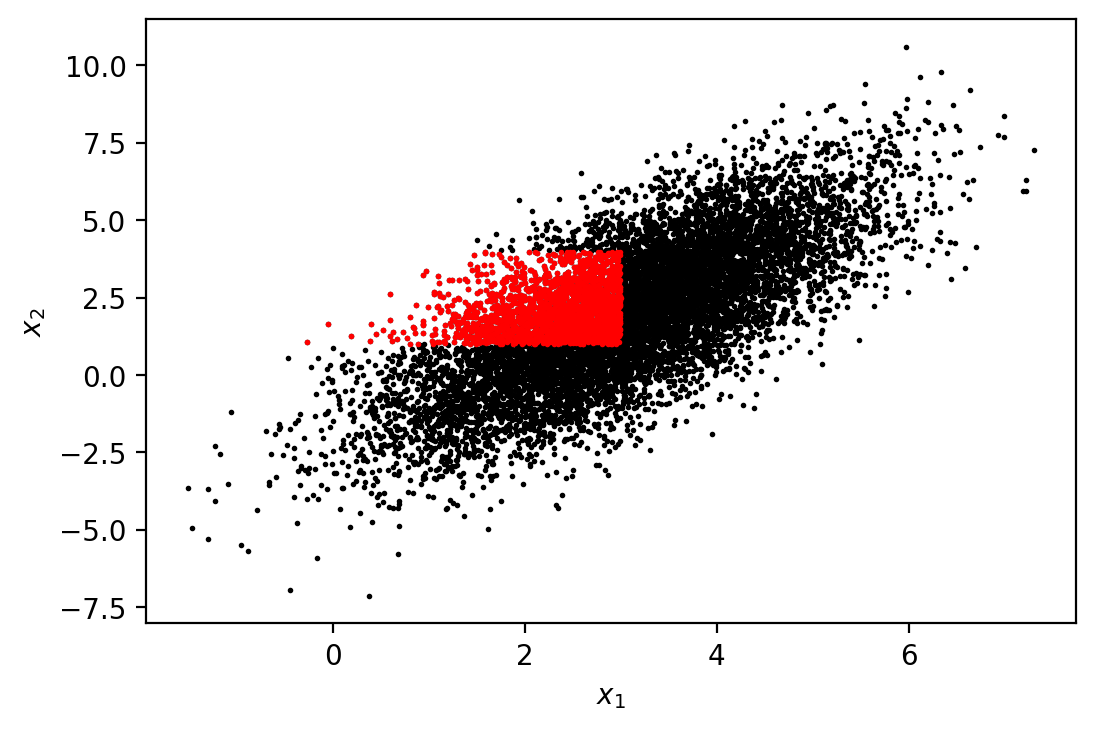

In [7]:
cov = np.array([[1.5, 2.], [2., 5.]])

samples = np.random.multivariate_normal(mu, cov, size=N)

mask = (-1. <= samples[:, 0]) & (samples[:, 0] <= 3.) & \
       (1. <= samples[:, 1]) & (samples[:, 1] <= 4.)
prob = np.sum(mask) / N
print(f'probability: {prob}')

plt.close('all')
fig, ax = plt.subplots(dpi=200)

ax.plot(samples[:, 0], samples[:, 1], 'o', c='k', ms=1)
ax.plot(samples[mask][:, 0], samples[mask][:, 1], 'o', c='r', ms=1)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

### Part C

You should have received different answers in both parts (and why not?  the shapes of the plotted distributions are different).  Let's do something a little different now.

Rotate your original coordinate system such that the covariance matrix in Part B is diagonalized.  Either rotate your data in Part B in this manner or generate a new set of points from the diagonalized covariance.  If you choose the latter method, make sure you rotate the mean position too!

Now calculate the probability that $u_1 < 0$ AND $u_2 < 0$ where $\{u_i\}$ is your new coordinate system.

Finally, succinctly explain what $u_1, u_2$ are in terms of the original coordinates $x_1, x_2$.

### Answer:

I chose to resample my points with a diagonalized covaraince matrix. I diagonalized the old covariance matrix using a similarity transformation with a unitary matrix $U$, and then I also rotated my mean such that $\mu' = U\mu$. After resampling I got a probability of about $P \approx 0.60$. The new coordinate system {$u_i$} is related to the principal components of the sample (however we did not subtract the mean). They describe the covariance in $x_1$ and $x_2$ as an orthogonal basis that is linearly uncorrelated.

probability: 0.5995


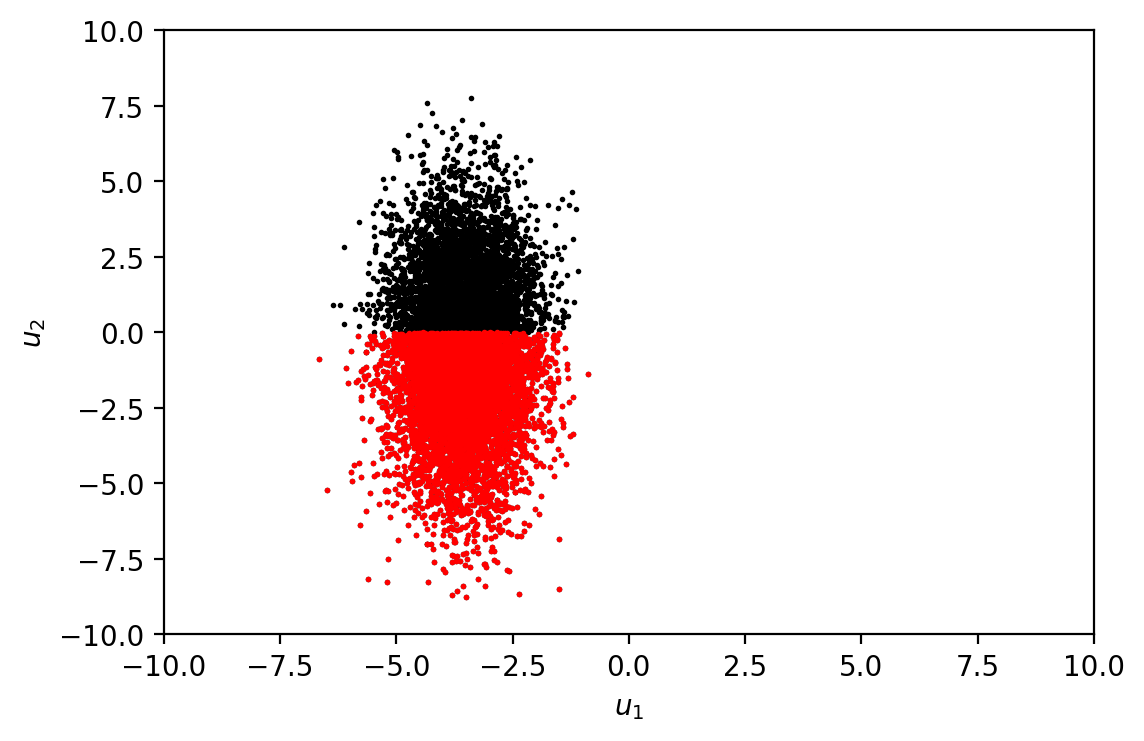

In [8]:
lam, U = np.linalg.eig(cov)
diag_cov = np.diag(lam)

# I tried rotating the points but for some reason it worked for U.T = U^{-1} but not U....
# new_samples = U @ samples.T
# new_samples = new_samples.T

# ...so instead I resampled points
new_mu = U @ mu
new_samples = np.random.multivariate_normal(new_mu, diag_cov, size=N)

mask = (new_samples[:, 0] < 0) & (new_samples[:, 1] < 0)
prob = np.sum(mask) / N
print(f'probability: {prob}')

plt.close('all')
fig, ax = plt.subplots(dpi=200)

ax.plot(new_samples[:, 0], new_samples[:, 1], 'o', c='k', ms=1)
ax.plot(new_samples[mask][:, 0], new_samples[mask][:, 1], 'o', c='r', ms=1)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')

plt.show()

You may have noticed you could have sampled the 'rotated positions' independently.  Rotating data such that their attributes are independent is the basis for principal components analysis, which we'll cover later.